In [1]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
from keras.models import load_model
import numpy as np
import coral_ordinal as coral
model = load_model("D:/models/FINAL/Mobile/Extra/agg_loss.h5")

In [3]:
import os
import pandas as pd
import cv2
import numpy as np
from scipy import special
test_images = []

for filename in os.listdir("D:/imdb/Align.5/Test/"):
    test_images.append(filename)

test_data = pd.read_csv("../dataset/APPA-REAL/appa-real-release/gt_avg_test.csv")
test_ages = round(test_data["apparent_age_avg"],2)

predictions = []
output_indexes1 = np.array([i for i in range(100)])

apparent_predictions = []
for idx, i in enumerate(test_images):
    image = cv2.imread('D:/imdb/Align.5/Test/' + i)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image_flipped = cv2.flip(image, 1)
    image = np.expand_dims(image, axis=0)
    image = image.astype('float32')/255

    image_flipped = np.expand_dims(image_flipped, axis=0)
    image_flipped = image_flipped.astype('float32')/255

    prediction = model.predict(image, verbose=False)
    prob = coral.ordinal_softmax(prediction[0]).numpy()
    predicted_ages = np.sum(prob * output_indexes1,axis = 1)

    prediction_flipped = model.predict(image_flipped, verbose=False)
    prob_flipped = coral.ordinal_softmax(prediction_flipped[0]).numpy()
    predicted_ages_flipped = np.sum(prob_flipped * output_indexes1,axis = 1)

    predicted_ages_avg = (predicted_ages + predicted_ages_flipped) / 2

    apparent_predictions.append(predicted_ages_avg)
    
mae = np.mean(np.abs(np.ravel(apparent_predictions) - test_ages))

print(mae)

4.292455167305189


'print(close_predictions)\nprint(far_predictions)'

In [4]:
import math
from math import e
predictions = np.ravel(apparent_predictions)

dev = test_data["apparent_age_std"]

errors = []
for i in range(len(predictions)):
    x = test_ages[i]
    mu = predictions[i]
    sigma = dev[i]
    error = 1 - math.exp(-((x - mu)**2) / (2 * sigma**2))
    errors.append(error)

mean_error = sum(errors) / len(errors)
print("Mean error:", mean_error)

Mean error: 0.3434442627791798


C:\Users\huish\AppData\Local\Temp\ipykernel_5544\3158640500.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  error = 1 - math.exp(-((x - mu)**2) / (2 * sigma**2))


4.292455167305189


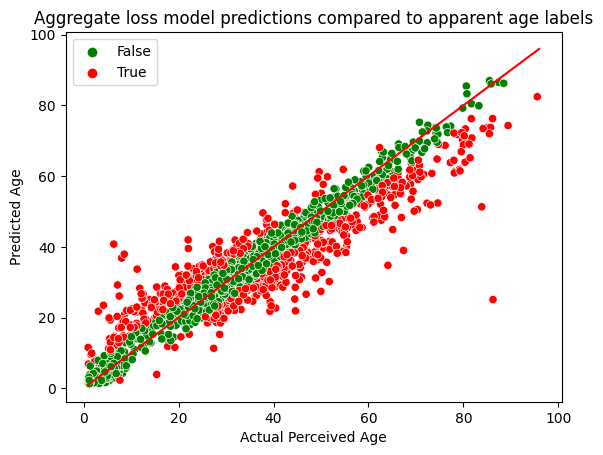

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(x=test_ages, y=np.ravel(apparent_predictions), hue=np.abs(np.ravel(apparent_predictions) - test_ages) > 5, palette=['green', 'red'], sizes=20)

sns.lineplot(x=np.arange(min(test_ages), max(test_ages)+1), y=np.arange(min(test_ages), max(test_ages)+1), color='red')
plt.xlabel("Actual Perceived Age")
plt.ylabel("Predicted Age")
plt.title('Aggregate loss model predictions compared to apparent age labels')
#plt.savefig("C:/Users/huish/Desktop/dissertation/Diss/result_images/multi_loss/prediction_scatter.png", bbox_inches='tight')
plt.show()

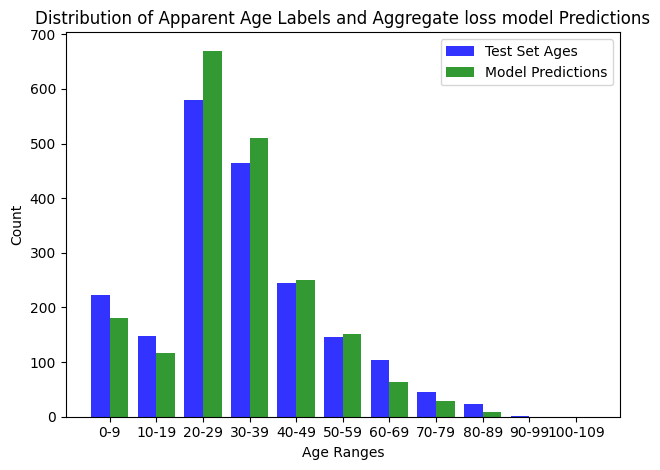

In [8]:
age_ranges = [i for i in range(0, 101, 10)]
apparent_predictions = np.ravel(apparent_predictions).tolist()

test_ages_grouped = [sum(1 for age in test_ages if age >= start_age and age < start_age + 10) for start_age in age_ranges]
apparent_predictions_grouped = [sum(1 for age in apparent_predictions if age >= start_age and age < start_age + 10) for start_age in age_ranges]


bar_width = 4
opacity = 0.8
plt.bar(age_ranges, test_ages_grouped, bar_width, alpha=opacity, color='b', label='Test Set Ages')
plt.bar(np.array(age_ranges)+bar_width, apparent_predictions_grouped, bar_width, alpha=opacity, color='g', label='Model Predictions')
plt.xlabel('Age Ranges')
plt.ylabel('Count')
plt.title('Distribution of Apparent Age Labels and Aggregate loss model Predictions')
plt.xticks([i+bar_width/2 for i in age_ranges], [str(start_age) + '-' + str(start_age+9) for start_age in age_ranges])

plt.legend()
plt.tight_layout()
#plt.savefig("C:/Users/huish/Desktop/dissertation/Diss/result_images/multi_loss/prediction_bar.png", bbox_inches='tight')
